In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터 파일 경로 확인
def check_file(file_path):
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found!")
    return file_path

# 데이터 로드
train_path = check_file('train.csv')
test_path = check_file('test.csv')
submission_path = check_file('sample_submission.csv')

train_df = pd.read_csv(train_path) if os.path.exists(train_path) else None
test_df = pd.read_csv(test_path) if os.path.exists(test_path) else None
submission_df = pd.read_csv(submission_path) if os.path.exists(submission_path) else None

if train_df is None or test_df is None:
    raise FileNotFoundError("Train or Test data file is missing. Please check file paths.")

# 결측치 확인 및 처리
def handle_missing_values(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna('Missing', inplace=True)  # 범주형 변수 → 'Missing' 대체
        else:
            df[col].fillna(df[col].median(), inplace=True)  # 수치형 변수 → 중앙값 대체
    return df

train_df = handle_missing_values(train_df)
test_df = handle_missing_values(test_df)

# 범주형 변수 인코딩 (훈련 & 테스트 데이터에서 동일하게 처리)
categorical_features = train_df.select_dtypes(include=['object']).columns

for col in categorical_features:
    lbl = LabelEncoder()
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0)  # 모든 데이터를 포함하여 인코딩
    lbl.fit(combined_data.astype(str))  # 훈련 & 테스트 데이터에서 fit 적용
    
    train_df[col] = lbl.transform(train_df[col].astype(str))
    test_df[col] = lbl.transform(test_df[col].astype(str))

# 타겟 변수 로그 변환
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 특성 엔지니어링 (건물 나이 계산)
train_df['Age'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['Age'] = test_df['YrSold'] - test_df['YearBuilt']

# 특성 및 타겟 분리
X = train_df.drop(columns=['Id', 'SalePrice'])
y = train_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/tmp/ipykernel_1618136/534386088.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)  # 수치형 변수 → 중앙값 대체
/tmp/ipykernel_1618136/534386088.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

In [34]:
# 다중공선성 확인 (VIF 계산)
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data.sort_values(by='VIF', ascending=False)

# VIF 값 계산 및 높은 값 제거
vif_result = calculate_vif(X_train)
print("VIF Analysis before feature removal:")
print(vif_result)

# VIF가 높은 변수 제거 (예: VIF > 10인 변수들 제거)
high_vif_columns = vif_result[vif_result["VIF"] > 10]["Feature"].tolist()
X_train = X_train.drop(columns=high_vif_columns)
X_test = X_test.drop(columns=high_vif_columns)

# 다시 VIF 계산
vif_result_after = calculate_vif(X_train)
print("VIF Analysis after feature removal:")
print(vif_result_after)

/opt/anaconda3/envs/house/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Analysis before feature removal:
         Feature       VIF
33    BsmtFinSF1       inf
35    BsmtFinSF2       inf
37   TotalBsmtSF       inf
36     BsmtUnfSF       inf
44  LowQualFinSF       inf
..           ...       ...
47  BsmtHalfBath  1.329423
69   ScreenPorch  1.308951
74       MiscVal  1.139610
8      Utilities  1.125621
68     3SsnPorch  1.075289

[80 rows x 2 columns]
VIF Analysis after feature removal:
          Feature       VIF
20    FireplaceQu  7.686978
30         MoSold  6.387003
6      Condition1  6.090481
13   BsmtExposure  5.751129
12     Foundation  5.543076
5    Neighborhood  5.424948
8      HouseStyle  4.837335
10       RoofMatl  4.763685
3       LotConfig  4.422734
22   GarageFinish  4.393715
9       RoofStyle  4.215561
14   BsmtFinType1  4.056713
21     GarageType  3.443258
1        LotShape  3.348405
0         LotArea  3.026169
19     Fireplaces  2.556206
16   BsmtFullBath  2.418557
15      HeatingQC  2.349101
18       HalfBath  2.209101
23     WoodDeckSF  1

In [35]:
# 모델 학습 및 평가
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# 모델 리스트
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
}

# 모델별 RMSE 평가
for name, model in models.items():
    rmse = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f'{name} RMSE: {rmse:.4f}')

Linear Regression RMSE: 0.2440
Random Forest RMSE: 0.2136
XGBoost RMSE: 0.2156


In [36]:
# 하이퍼파라미터 튜닝 (GridSearchCV)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
gs_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=kfold, scoring='neg_root_mean_squared_error', verbose=1)
gs_xgb.fit(X_train, y_train)

best_xgb = gs_xgb.best_estimator_
print(f'Best XGBoost RMSE: {evaluate_model(best_xgb, X_train, y_train, X_test, y_test):.4f}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best XGBoost RMSE: 0.2014


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

# 테스트 데이터 크기 확인
print(f"✅ 원본 테스트 데이터 크기: {test_df.shape}")

# 테스트 데이터 컬럼 순서 및 데이터 타입 확인
X_test = test_df.drop(columns=['Id'])  # 'Id' 컬럼 제거
X_test = X_test.astype(np.float64)  # 모든 데이터를 float64로 변환
X_test = X_test[best_xgb.feature_names_in_]  # 컬럼 순서 맞추기

# 최종 테스트 데이터 크기 확인
print(f"✅ 변환 후 테스트 데이터 크기: {X_test.shape}")

# 예측 실행
y_pred = best_xgb.predict(X_test)
print(f"✅ 최종 예측값 크기: {y_pred.shape}")  # (1459,) 확인

# CSV 저장
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": np.expm1(y_pred)})
submission.to_csv("submission.csv", index=False)

print("✅ Kaggle 제출 파일이 생성되었습니다: submission.csv")


🚨 테스트 데이터에 없는 컬럼: set()
🚨 훈련 데이터에 없는 컬럼: set()
✅ 최종 테스트 데이터 컬럼: ['LotArea', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold']
✅ 최종 테스트 데이터 dtype: [dtype('float64')]
✅ 테스트 데이터 크기: (292, 31)
✅ 예측값 크기: (292,)


ValueError: array length 292 does not match index length 1459

In [43]:
# 1️⃣ DataFrame 유지
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=best_xgb.feature_names_in_)

# 2️⃣ 데이터 타입 변환 (모든 컬럼을 float64로 통일)
X_test = X_test.astype(np.float64)

# 3️⃣ 모델이 학습한 컬럼 순서대로 정렬
X_test = X_test[best_xgb.feature_names_in_]

# 4️⃣ 최종적으로 컬럼과 데이터 타입 확인
print("✅ 최종 테스트 데이터 컬럼:", X_test.columns.tolist())
print("✅ 최종 테스트 데이터 dtype:", X_test.dtypes.unique())

# 5️⃣ 예측 실행
y_pred = best_xgb.predict(X_test)

✅ 최종 테스트 데이터 컬럼: ['LotArea', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold']
✅ 최종 테스트 데이터 dtype: [dtype('float64')]


In [44]:
# 최종 예측 실행
y_pred = best_xgb.predict(X_test)

In [46]:
# Kaggle 제출을 위한 함수
def create_submission(model, X_test, test_df, model_name):
    """ 테스트 데이터에 대한 예측을 수행하고 Kaggle 제출 파일 생성 """
    y_pred = model.predict(X_test)  # 예측값 생성

    # 로그 변환을 되돌리기 (expm1)
    y_pred = np.expm1(y_pred)

    # 제출 파일 생성
    submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": np.expm1(y_pred)})  # 로그 변환 해제
    submission.to_csv("submission2.csv", index=False)  # CSV 파일 저장

    print("✅ Kaggle 제출 파일이 생성되었습니다: submission.csv")

# 가장 성능이 좋은 모델을 선택하여 제출 파일 생성
best_model = best_xgb  # RMSE 확인 후 가장 성능 좋은 모델 선택
create_submission(best_model, test_df.drop(columns=['Id']), test_df, "XGBoost")

ValueError: feature_names mismatch: ['LotArea', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold'] ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'Age']
training data did not have the following fields: BsmtQual, LandContour, BsmtCond, 1stFlrSF, Fence, Age, OverallQual, MiscFeature, GarageCond, GarageYrBlt, YearRemodAdd, FullBath, GarageArea, MSSubClass, SaleType, BsmtFinSF1, Condition2, ExterQual, MasVnrType, KitchenQual, Street, GrLivArea, PavedDrive, KitchenAbvGr, YrSold, Alley, OverallCond, ExterCond, Electrical, BsmtUnfSF, MSZoning, TotRmsAbvGrd, BsmtFinType2, Heating, TotalBsmtSF, PoolQC, YearBuilt, CentralAir, GarageCars, SaleCondition, BsmtFinSF2, 2ndFlrSF, Functional, Exterior2nd, LowQualFinSF, BedroomAbvGr, GarageQual, Exterior1st, LotFrontage

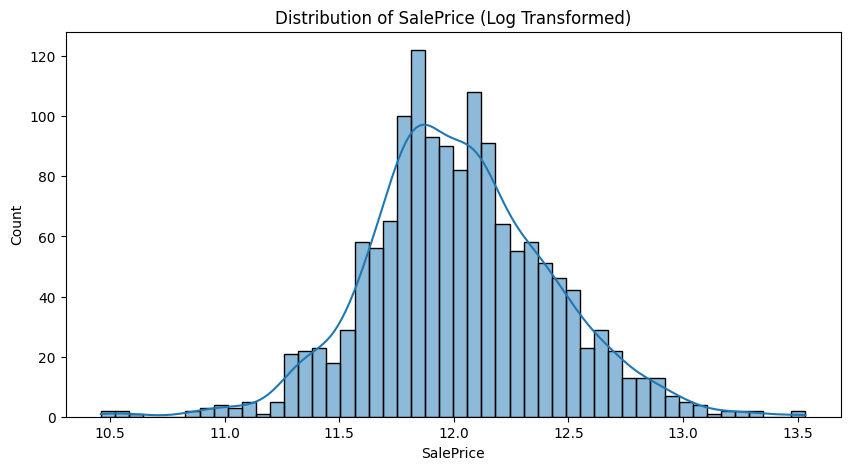

In [10]:
# 결과 시각화 (SalePrice 분포 확인)
plt.figure(figsize=(10,5))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice (Log Transformed)')
plt.show()